# 用于预训练词嵌入的数据集

In [1]:
import math
import os
import random
import torch

In [2]:
import os
import requests
import hashlib
import zipfile
import collections
import torch

# --- 模拟 d2l 的数据下载与解压功能 ---

# 1. 定义数据中心字典，替代 d2l.DATA_HUB
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB['ptb'] = (DATA_URL + 'ptb.zip',
                   '319d85e578af0cdc590547f26231e4e31cdf1e42')

def download_extract(name, cache_dir=os.path.join('.', 'data')):
    """
    一个与 d2l.download_extract 동名的独立函数，用于下载和解压数据。
    """
    # 从 DATA_HUB 获取 URL 和哈希值
    url, sha1_hash = DATA_HUB[name]
    
    # 确保缓存目录存在
    os.makedirs(cache_dir, exist_ok=True)
    zip_filepath = os.path.join(cache_dir, url.split('/')[-1])
    
    # --- 下载逻辑 ---
    if not os.path.exists(zip_filepath):
        print(f'正在下载 {url} ...')
        try:
            r = requests.get(url, stream=True, verify=True)
            r.raise_for_status()
            with open(zip_filepath, 'wb') as f:
                f.write(r.content)
        except Exception as e:
            print(f"下载出错: {e}")
            return None
    
    # --- 验证逻辑 ---
    with open(zip_filepath, 'rb') as f:
        sha1 = hashlib.sha1()
        sha1.update(f.read())
        if sha1.hexdigest() != sha1_hash:
            print(f"文件哈希值不匹配: {zip_filepath}")
            return None
    
    # --- 解压逻辑 ---
    final_data_dir = os.path.join(cache_dir, name)
    if not os.path.exists(final_data_dir):
        print(f'正在解压 {zip_filepath}...')
        with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
            zip_ref.extractall(os.path.dirname(zip_filepath))
    
    return final_data_dir


#@save
def read_ptb():
    """将PTB数据集加载到文本行的列表中"""
    # 唯一的改动：调用我们自己的 download_extract 函数
    data_dir = download_extract('ptb')
    if not data_dir:
        print("无法获取PTB数据目录，程序终止。")
        return []

    # 以下文件读取逻辑保持不变
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n') if line]


sentences = read_ptb()
print(f'\n# sentences数: {len(sentences)}')

# 打印前两个句子作为示例
if len(sentences) > 1:
    print(f'第一个句子: {sentences[0]}')
    print(f'第二个句子: {sentences[1]}')

正在下载 http://d2l-data.s3-accelerate.amazonaws.com/ptb.zip ...
正在解压 ./data/ptb.zip...

# sentences数: 42068
第一个句子: ['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro-quebec', 'ipo', 'kia', 'memotec', 'mlx', 'nahb', 'punts', 'rake', 'regatta', 'rubens', 'sim', 'snack-food', 'ssangyong', 'swapo', 'wachter']
第二个句子: ['pierre', '<unk>', 'N', 'years', 'old', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', 'N']


In [3]:
class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


vocab = Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

In [4]:
#@save
def subsample(sentences, vocab):
    """下采样高频词"""
    # 排除未知词元'<unk>'
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]
    counter = count_corpus(sentences)
    num_tokens = sum(counter.values())

    # 如果在下采样期间保留词元，则返回True
    def keep(token):
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))

    return ([[token for token in line if keep(token)] for line in sentences],
            counter)

subsampled, counter = subsample(sentences, vocab)

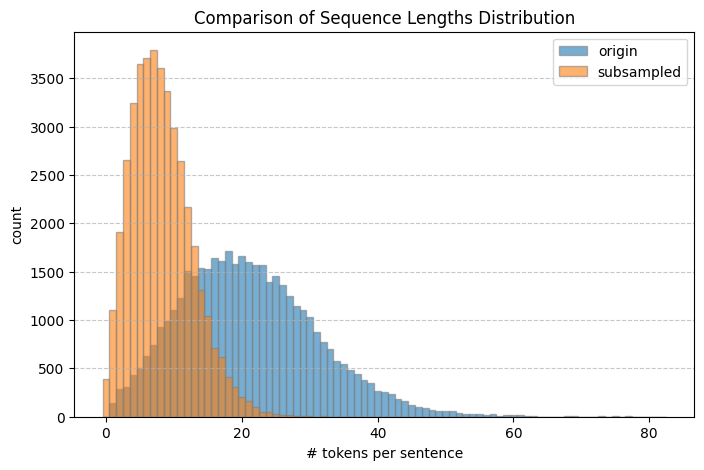

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random # 用于生成示例数据

def show_list_len_pair_hist(labels, xlabel, ylabel, list1, list2):
    """
    绘制两个列表的元素长度分布的直方图，用于对比。
    此函数为 d2l.show_list_len_pair_hist 的替代实现。
    
    参数:
    labels (list of str): 两个分布的标签，例如 ['origin', 'subsampled']。
    xlabel (str): x轴的标签。
    ylabel (str): y轴的标签。
    list1 (list of list): 第一个数据列表。
    list2 (list of list): 第二个数据列表。
    """
    # 1. 计算每个列表中元素的长度
    lengths1 = [len(item) for item in list1]
    lengths2 = [len(item) for item in list2]
    
    # 2. 设置画布大小
    plt.figure(figsize=(8, 5))
    
    # 3. 确定一个合适的、能覆盖所有数据的 Bins（分箱）范围
    # 这样可以确保两个直方图的x轴是对齐的
    try:
        max_len = max(max(lengths1), max(lengths2))
    except ValueError: # 处理空列表的情况
        max_len = 10
    bins = np.arange(0, max_len + 2) - 0.5 # 让整数值位于柱子中央
    
    # 4. 在同一个坐标轴上绘制两个直方图
    # 使用 alpha 参数设置透明度，以便观察重叠部分
    plt.hist(lengths1, bins=bins, alpha=0.6, label=labels[0], edgecolor='gray')
    plt.hist(lengths2, bins=bins, alpha=0.6, label=labels[1], edgecolor='gray')
    
    # 5. 添加标签、标题、图例和网格
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.title('Comparison of Sequence Lengths Distribution')
    
    # 6. 显示图表
    plt.show()



# 原来的调用方式:
# d2l.show_list_len_pair_hist(
#     ['origin', 'subsampled'], '# tokens per sentence',
#     'count', sentences, subsampled);

# 现在调用我们自己实现的函数:
show_list_len_pair_hist(
    ['origin', 'subsampled'], '# tokens per sentence',
    'count', sentences, subsampled)

In [ ]:
def compare_counts(token):
    return (f'"{token}"的数量：'
            f'之前={sum([l.count(token) for l in sentences])}, '
            f'之后={sum([l.count(token) for l in subsampled])}')

compare_counts('the')

#

'"the"的数量：之前=50770, 之后=2053'

In [7]:
compare_counts('join')

'"join"的数量：之前=45, 之后=45'

In [8]:
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [71, 392, 2115, 274, 406], [5277, 3054, 1580]]

In [9]:
#@save
def get_centers_and_contexts(corpus, max_window_size):
    """返回跳元模型中的中心词和上下文词"""
    centers, contexts = [], []
    for line in corpus:
        # 要形成“中心词-上下文词”对，每个句子至少需要有2个词
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # 上下文窗口中间i
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # 从上下文词中排除中心词
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

In [ ]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('数据集', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('中心词', center, '的上下文词是', context)

# 数据集 [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
# 中心词 0 的上下文词是 [1, 2]
# 中心词 1 的上下文词是 [0, 2]
# 中心词 2 的上下文词是 [1, 3]
# 中心词 3 的上下文词是 [2, 4]
# 中心词 4 的上下文词是 [3, 5]
# 中心词 5 的上下文词是 [3, 4, 6]
# 中心词 6 的上下文词是 [5]
# 中心词 7 的上下文词是 [8]
# 中心词 8 的上下文词是 [7, 9]
# 中心词 9 的上下文词是 [7, 8]

数据集 [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
中心词 0 的上下文词是 [1, 2]
中心词 1 的上下文词是 [0, 2]
中心词 2 的上下文词是 [1, 3]
中心词 3 的上下文词是 [2, 4]
中心词 4 的上下文词是 [3, 5]
中心词 5 的上下文词是 [3, 4, 6]
中心词 6 的上下文词是 [5]
中心词 7 的上下文词是 [8]
中心词 8 的上下文词是 [7, 9]
中心词 9 的上下文词是 [7, 8]


In [ ]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# “中心词-上下文词对”的数量: {sum([len(contexts) for contexts in all_contexts])}'

# '# “中心词-上下文词对”的数量: 1501718'

'# “中心词-上下文词对”的数量: 1501718'

In [12]:
class RandomGenerator:
    """根据n个采样权重在{1,...,n}中随机抽取"""
    def __init__(self, sampling_weights):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # 缓存k个随机采样结果
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

In [ ]:
#@save
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

# [2, 2, 3, 3, 3, 3, 3, 2, 3, 3]

[2, 2, 3, 3, 3, 3, 3, 2, 3, 3]

In [14]:
#@save
def get_negatives(all_contexts, vocab, counter, K):
    """返回负采样中的噪声词"""
    # 索引为1、2、...（索引0是词表中排除的未知标记）
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # 噪声词不能是上下文词
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

In [15]:
#@save
def batchify(data):
    """返回带有负采样的跳元模型的小批量样本"""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += \
            [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

In [ ]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)


# centers = tensor([[1],
#         [1]])
# contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
#         [2, 2, 2, 3, 3, 0]])
# masks = tensor([[1, 1, 1, 1, 1, 1],
#         [1, 1, 1, 1, 1, 0]])
# labels = tensor([[1, 1, 0, 0, 0, 0],
#         [1, 1, 1, 0, 0, 0]])

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


In [22]:
class PTBDataset(torch.utils.data.Dataset):
    def __init__(self, centers, contexts, negatives):
        assert len(centers) == len(contexts) == len(negatives)
        self.centers = centers
        self.contexts = contexts
        self.negatives = negatives

    def __getitem__(self, index):
        return (self.centers[index], self.contexts[index],
                self.negatives[index])

    def __len__(self):
        return len(self.centers)


def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """下载PTB数据集，然后将其加载到内存中"""
    sentences = read_ptb()
    vocab = Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True,
        collate_fn=batchify)
    return data_iter, vocab

In [23]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


# 预训练word2vec

In [1]:
import math
import os
import random
import torch

import requests
import hashlib
import zipfile
import collections
import torch


DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB['ptb'] = (DATA_URL + 'ptb.zip',
                   '319d85e578af0cdc590547f26231e4e31cdf1e42')

def download_extract(name, cache_dir=os.path.join('.', 'data')):
    """
    一个与 d2l.download_extract 동名的独立函数，用于下载和解压数据。
    """
    # 从 DATA_HUB 获取 URL 和哈希值
    url, sha1_hash = DATA_HUB[name]
    
    # 确保缓存目录存在
    os.makedirs(cache_dir, exist_ok=True)
    zip_filepath = os.path.join(cache_dir, url.split('/')[-1])
    
    # --- 下载逻辑 ---
    if not os.path.exists(zip_filepath):
        print(f'正在下载 {url} ...')
        try:
            r = requests.get(url, stream=True, verify=True)
            r.raise_for_status()
            with open(zip_filepath, 'wb') as f:
                f.write(r.content)
        except Exception as e:
            print(f"下载出错: {e}")
            return None
    
    # --- 验证逻辑 ---
    with open(zip_filepath, 'rb') as f:
        sha1 = hashlib.sha1()
        sha1.update(f.read())
        if sha1.hexdigest() != sha1_hash:
            print(f"文件哈希值不匹配: {zip_filepath}")
            return None
    
    # --- 解压逻辑 ---
    final_data_dir = os.path.join(cache_dir, name)
    if not os.path.exists(final_data_dir):
        print(f'正在解压 {zip_filepath}...')
        with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
            zip_ref.extractall(os.path.dirname(zip_filepath))
    
    return final_data_dir


def read_ptb():
    """将PTB数据集加载到文本行的列表中"""
    # 唯一的改动：调用我们自己的 download_extract 函数
    data_dir = download_extract('ptb')
    if not data_dir:
        print("无法获取PTB数据目录，程序终止。")
        return []

    # 以下文件读取逻辑保持不变
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n') if line]


class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


def subsample(sentences, vocab):
    """下采样高频词"""
    # 排除未知词元'<unk>'
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]
    counter = count_corpus(sentences)
    num_tokens = sum(counter.values())

    # 如果在下采样期间保留词元，则返回True
    def keep(token):
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))

    return ([[token for token in line if keep(token)] for line in sentences],
            counter)


def compare_counts(token):
    return (f'"{token}"的数量：'
            f'之前={sum([l.count(token) for l in sentences])}, '
            f'之后={sum([l.count(token) for l in subsampled])}')


def get_centers_and_contexts(corpus, max_window_size):
    """返回跳元模型中的中心词和上下文词"""
    centers, contexts = [], []
    for line in corpus:
        # 要形成“中心词-上下文词”对，每个句子至少需要有2个词
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # 上下文窗口中间i
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # 从上下文词中排除中心词
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts


class RandomGenerator:
    """根据n个采样权重在{1,...,n}中随机抽取"""
    def __init__(self, sampling_weights):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # 缓存k个随机采样结果
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]


def get_negatives(all_contexts, vocab, counter, K):
    """返回负采样中的噪声词"""
    # 索引为1、2、...（索引0是词表中排除的未知标记）
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # 噪声词不能是上下文词
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives


def batchify(data):
    """返回带有负采样的跳元模型的小批量样本"""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += \
            [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))


class PTBDataset(torch.utils.data.Dataset):
    def __init__(self, centers, contexts, negatives):
        assert len(centers) == len(contexts) == len(negatives)
        self.centers = centers
        self.contexts = contexts
        self.negatives = negatives

    def __getitem__(self, index):
        return (self.centers[index], self.contexts[index],
                self.negatives[index])

    def __len__(self):
        return len(self.centers)


def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """下载PTB数据集，然后将其加载到内存中"""
    sentences = read_ptb()
    vocab = Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True,
        collate_fn=batchify)
    return data_iter, vocab

In [9]:
import math
import torch
from torch import nn

batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = load_data_ptb(batch_size, max_window_size,
                                     num_noise_words)

In [ ]:
import torch.nn as nn
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      f'dtype={embed.weight.dtype})')

# Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


In [3]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

In [ ]:
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

# torch.Size([2, 1, 4])

torch.Size([2, 1, 4])

In [5]:
class SigmoidBCELoss(nn.Module):
    # 带掩码的二元交叉熵损失
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

In [ ]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

# tensor([0.9352, 1.8462])

tensor([0.9352, 1.8462])

In [7]:
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


In [10]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))

In [20]:
def train(net, data_iter, lr, num_epochs):
    """不依赖d2l包的Word2Vec训练函数"""
    # 加载必要的库
    import torch
    from torch import nn
    import time
    import matplotlib.pyplot as plt

    # 1. 设置设备 (GPU or CPU)
    device = torch.device("mps" if torch.mps.is_available() else "cpu")
    print(f"Training on {device}...")

    # 2. 初始化网络权重
    def init_weights(m):
        if isinstance(m, nn.Embedding):
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net = net.to(device)

    # 3. 定义优化器
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    # 4. 使用列表存储每个epoch的损失
    loss_history = []

    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss, total_tokens, num_batches = 0.0, 0, len(data_iter)
        
        net.train() # 设置为训练模式
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            
            # 将数据移动到指定设备
            center, context_negative, mask, label = [
                data.to(device) for data in batch
            ]
            
            # 前向传播计算预测值和损失
            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask) 
                 / mask.sum(axis=1) * mask.shape[1])
            
            # 反向传播和优化
            l.sum().backward()
            optimizer.step()
            
            # 累加损失和处理的token数量
            total_loss += l.sum().item()
            total_tokens += l.numel()
        
        # 计算并记录当前epoch的平均损失
        epoch_loss = total_loss / total_tokens
        loss_history.append(epoch_loss)
        
        # 打印当前epoch的训练信息
        epoch_time = time.time() - start_time
        tokens_per_sec = total_tokens / epoch_time
        
        print(f'Epoch {epoch + 1:02d}/{num_epochs}, '
              f'Loss: {epoch_loss:.4f}, '
              f'{tokens_per_sec:.1f} tokens/sec')

    print(f'\nTraining finished. Final loss: {loss_history[-1]:.4f}')

    # 绘图
    plt.figure()
    plt.plot(range(1, num_epochs + 1), loss_history, marker='o')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(1, num_epochs + 1))
    plt.grid()
    plt.show()

    # 返回损失历史记录  
    return loss_history

Training on mps...
Epoch 01/5, Loss: 0.4806, 28951.6 tokens/sec
Epoch 02/5, Loss: 0.4254, 31270.2 tokens/sec
Epoch 03/5, Loss: 0.4031, 29409.7 tokens/sec
Epoch 04/5, Loss: 0.3798, 29246.7 tokens/sec
Epoch 05/5, Loss: 0.3592, 33652.2 tokens/sec

Training finished. Final loss: 0.3592


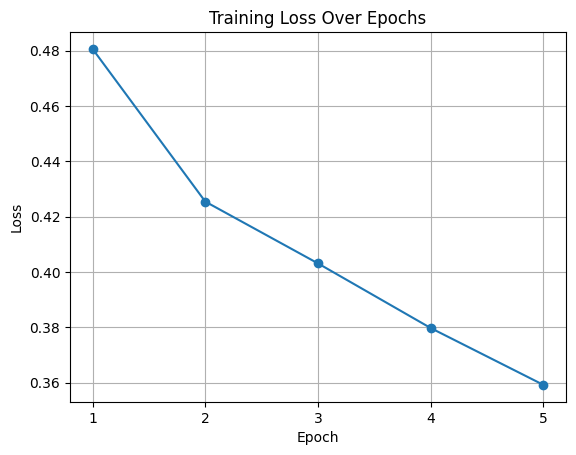

[0.4805784340695549,
 0.4254359654030575,
 0.4031074643041177,
 0.3797615021935807,
 0.3592291774276477]

In [21]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

In [ ]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # 计算余弦相似性。增加1e-9以获得数值稳定性
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # 删除输入词
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('chip', 3, net[0])

# cosine sim=0.708: desktop
# cosine sim=0.699: intel
# cosine sim=0.695: microprocessor

cosine sim=0.708: desktop
cosine sim=0.699: intel
cosine sim=0.695: microprocessor


# 子词嵌入

In [23]:
import collections

symbols = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
           'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
           '_', '[UNK]']

In [ ]:
raw_token_freqs = {'fast_': 4, 'faster_': 3, 'tall_': 5, 'taller_': 4}
token_freqs = {}
for token, freq in raw_token_freqs.items():
    token_freqs[' '.join(list(token))] = raw_token_freqs[token]
token_freqs

# {'f a s t _': 4, 'f a s t e r _': 3, 't a l l _': 5, 't a l l e r _': 4}

{'f a s t _': 4, 'f a s t e r _': 3, 't a l l _': 5, 't a l l e r _': 4}

In [25]:
def get_max_freq_pair(token_freqs):
    pairs = collections.defaultdict(int)
    for token, freq in token_freqs.items():
        symbols = token.split()
        for i in range(len(symbols) - 1):
            # “pairs”的键是两个连续符号的元组
            pairs[symbols[i], symbols[i + 1]] += freq
    return max(pairs, key=pairs.get)  # 具有最大值的“pairs”键

In [26]:
def merge_symbols(max_freq_pair, token_freqs, symbols):
    symbols.append(''.join(max_freq_pair))
    new_token_freqs = dict()
    for token, freq in token_freqs.items():
        new_token = token.replace(' '.join(max_freq_pair),
                                  ''.join(max_freq_pair))
        new_token_freqs[new_token] = token_freqs[token]
    return new_token_freqs

In [27]:
def merge_symbols(max_freq_pair, token_freqs, symbols):
    symbols.append(''.join(max_freq_pair))
    new_token_freqs = dict()
    for token, freq in token_freqs.items():
        new_token = token.replace(' '.join(max_freq_pair),
                                  ''.join(max_freq_pair))
        new_token_freqs[new_token] = token_freqs[token]
    return new_token_freqs

In [ ]:
num_merges = 10
for i in range(num_merges):
    max_freq_pair = get_max_freq_pair(token_freqs)
    token_freqs = merge_symbols(max_freq_pair, token_freqs, symbols)
    print(f'合并# {i+1}:',max_freq_pair)
# 合并# 1: ('t', 'a')
# 合并# 2: ('ta', 'l')
# 合并# 3: ('tal', 'l')
# 合并# 4: ('f', 'a')
# 合并# 5: ('fa', 's')
# 合并# 6: ('fas', 't')
# 合并# 7: ('e', 'r')
# 合并# 8: ('er', '_')
# 合并# 9: ('tall', '_')
# 合并# 10: ('fast', '_')

合并# 1: ('t', 'a')
合并# 2: ('ta', 'l')
合并# 3: ('tal', 'l')
合并# 4: ('f', 'a')
合并# 5: ('fa', 's')
合并# 6: ('fas', 't')
合并# 7: ('e', 'r')
合并# 8: ('er', '_')
合并# 9: ('tall', '_')
合并# 10: ('fast', '_')


In [ ]:
print(symbols)

# ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[UNK]', 'ta', 'tal', 'tall', 'fa', 'fas', 'fast', 'er', 'er_', 'tall_', 'fast_']

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[UNK]', 'ta', 'tal', 'tall', 'fa', 'fas', 'fast', 'er', 'er_', 'tall_', 'fast_']


In [ ]:
print(list(token_freqs.keys()))

# ['fast_', 'fast er_', 'tall_', 'tall er_']

['fast_', 'fast er_', 'tall_', 'tall er_']


In [31]:
def segment_BPE(tokens, symbols):
    outputs = []
    for token in tokens:
        start, end = 0, len(token)
        cur_output = []
        # 具有符号中可能最长子字的词元段
        while start < len(token) and start < end:
            if token[start: end] in symbols:
                cur_output.append(token[start: end])
                start = end
                end = len(token)
            else:
                end -= 1
        if start < len(token):
            cur_output.append('[UNK]')
        outputs.append(' '.join(cur_output))
    return outputs

In [ ]:
tokens = ['tallest_', 'fatter_']
print(segment_BPE(tokens, symbols))

# ['tall e s t _', 'fa t t er_']

['tall e s t _', 'fa t t er_']


# 词的相似性和类比任务

In [33]:
import os
import torch
from torch import nn

In [34]:
import os
import requests
import hashlib
import zipfile
import tarfile
from tqdm import tqdm

def download_and_extract(name, cache_dir=os.path.join('.', 'data')):
    """
    下载并解压预定义的数据集。

    Args:
        name (str): 数据集的名称 (e.g., 'glove.6b.50d').
        cache_dir (str): 用于存储下载文件的本地目录。

    Returns:
        str: 解压后数据所在的文件夹路径。
    """
    # 1. 定义数据信息 (URL 和 SHA-1 校验和)
    DATA_HUB = {
        'glove.6b.50d': ('http://d2l-data.s3-accelerate.amazonaws.com/glove.6B.50d.zip',
                         '0b8703943ccdb6eb788e6f091b8946e82231bc4d'),
        'glove.6b.100d': ('http://d2l-data.s3-accelerate.amazonaws.com/glove.6B.100d.zip',
                          'cd43bfb07e44e6f27cbcc7bc9ae3d80284fdaf5a'),
        'glove.42b.300d': ('http://d2l-data.s3-accelerate.amazonaws.com/glove.42B.300d.zip',
                           'b5116e234e9eb9076672cfeabf5469f3eec904fa'),
        'wiki.en': ('http://d2l-data.s3-accelerate.amazonaws.com/wiki.en.zip',
                    'c1816da3821ae9f43899be655002f6c723e91b88')
    }

    if name not in DATA_HUB:
        raise ValueError(f"未定义的数据集: {name}")

    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    dest_dir = os.path.join(cache_dir, name.replace('.', '_')) # 创建一个唯一的解压目录名

    # 2. 下载文件 (如果本地不存在)
    if not os.path.exists(fname):
        print(f"正在从 {url} 下载 {fname}...")
        try:
            r = requests.get(url, stream=True, timeout=30)
            r.raise_for_status() # 如果请求失败则引发异常
            total_size = int(r.headers.get('content-length', 0))
            
            with open(fname, 'wb') as f, tqdm(
                desc=fname, total=total_size, unit='iB', unit_scale=True
            ) as bar:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
                    bar.update(len(chunk))
        except Exception as e:
            if os.path.exists(fname):
                os.remove(fname)
            print(f"下载错误: {e}")
            return None
    
    # 3. 校验文件
    sha1 = hashlib.sha1()
    with open(fname, 'rb') as f:
        while True:
            data = f.read(1048576) # 1MB 块
            if not data:
                break
            sha1.update(data)
    
    if sha1.hexdigest() != sha1_hash:
        print(f"SHA1 校验和不匹配。文件 {fname} 可能已损坏。")
        # os.remove(fname) # 可选择删除损坏的文件
        return None
    print(f"文件 {fname} 校验成功。")

    # 4. 解压文件
    if not os.path.exists(dest_dir) or not os.listdir(dest_dir):
        print(f"正在解压 {fname} 到 {dest_dir}...")
        if fname.endswith('.zip'):
            with zipfile.ZipFile(fname, 'r') as zf:
                zf.extractall(dest_dir)
        elif fname.endswith(('.tar', '.gz', '.tgz')):
             with tarfile.open(fname, 'r') as tf:
                tf.extractall(dest_dir)
        else:
             print(f"不支持的文件格式: {fname}")
             return fname # 如果不是压缩文件，直接返回文件路径
    
    return dest_dir

# --- 如何使用 ---
if __name__ == '__main__':
    print("下载 GloVe 50维词向量...")
    glove_50d_dir = download_and_extract('glove.6b.50d')
    if glove_50d_dir:
        print(f"GloVe 50d 数据已准备好，位于: {glove_50d_dir}")
        # 你可以列出文件来确认
        print("文件夹内容:", os.listdir(glove_50d_dir))

    print("\n" + "="*30 + "\n")

    print("下载英文维基百科数据集...")
    wiki_en_dir = download_and_extract('wiki.en')
    if wiki_en_dir:
        print(f"wiki.en 数据已准备好，位于: {wiki_en_dir}")
        print("文件夹内容:", os.listdir(wiki_en_dir))

下载 GloVe 50维词向量...
正在从 http://d2l-data.s3-accelerate.amazonaws.com/glove.6B.50d.zip 下载 ./data/glove.6B.50d.zip...


./data/glove.6B.50d.zip: 100%|██████████| 69.2M/69.2M [00:07<00:00, 9.61MiB/s]


文件 ./data/glove.6B.50d.zip 校验成功。
正在解压 ./data/glove.6B.50d.zip 到 ./data/glove_6b_50d...
GloVe 50d 数据已准备好，位于: ./data/glove_6b_50d
文件夹内容: ['glove.6B.50d']


下载英文维基百科数据集...
正在从 http://d2l-data.s3-accelerate.amazonaws.com/wiki.en.zip 下载 ./data/wiki.en.zip...


./data/wiki.en.zip: 100%|██████████| 2.47G/2.47G [03:55<00:00, 10.5MiB/s] 


文件 ./data/wiki.en.zip 校验成功。
正在解压 ./data/wiki.en.zip 到 ./data/wiki_en...
wiki.en 数据已准备好，位于: ./data/wiki_en
文件夹内容: ['wiki.en']


In [42]:
import os
import torch
import requests
import zipfile
from tqdm import tqdm

def _download_embedding_if_needed(name, cache_dir=os.path.join('.', 'data')):
    """
    一个独立的辅助函数，用于下载和解压GloVe词向量。
    该版本能自动在压缩包内查找正确的 .txt 文件名。
    """
    DATA_HUB = {
        'glove.6b.50d': ('http://d2l-data.s3-accelerate.amazonaws.com/glove.6B.50d.zip',),
        'glove.6b.100d': ('http://d2l-data.s3-accelerate.amazonaws.com/glove.6B.100d.zip',)
    }
    
    if name not in DATA_HUB:
        raise ValueError(f"未定义的数据集名称: {name}")

    url, = DATA_HUB[name]
    
    os.makedirs(cache_dir, exist_ok=True)
    zip_path = os.path.join(cache_dir, url.split('/')[-1])
    
    # 首先检查最终解压出的文件是否已存在，这需要动态确定文件名
    # 我们先假设一个文件名，如果不存在再继续
    potential_fname = name + '.txt' # 例如 'glove.6b.50d.txt'
    embedding_path = os.path.join(cache_dir, potential_fname)

    if not os.path.exists(embedding_path):
        print(f"本地未找到词向量文件，开始下载和解压流程...")
        
        if not os.path.exists(zip_path):
            print(f"正在下载 {url} ...")
            try:
                r = requests.get(url, stream=True, timeout=60)
                r.raise_for_status()
                total_size = int(r.headers.get('content-length', 0))
                with open(zip_path, 'wb') as f, tqdm(
                    desc=name, total=total_size, unit='iB', unit_scale=True
                ) as bar:
                    for chunk in r.iter_content(chunk_size=8192):
                        f.write(chunk)
                        bar.update(len(chunk))
            except requests.exceptions.RequestException as e:
                if os.path.exists(zip_path): os.remove(zip_path)
                raise IOError(f"下载文件时出错: {e}")

        print(f"正在解压 {zip_path}...")
        with zipfile.ZipFile(zip_path, 'r') as zf:
            # ===================================================================
            #   关键修改：不再硬编码文件名，而是自动在压缩包内查找
            # ===================================================================
            txt_filename = ''
            for file_in_zip in zf.namelist():
                if file_in_zip.lower().endswith('.txt'):
                    txt_filename = file_in_zip
                    break
            
            if not txt_filename:
                raise IOError(f"在 {zip_path} 中未找到 .txt 文件。")
            
            # 使用找到的文件名进行解压
            print(f"在压缩包中找到文件: {txt_filename}, 正在解压...")
            zf.extract(txt_filename, cache_dir)
            # 更新正确的最终文件路径
            embedding_path = os.path.join(cache_dir, txt_filename)
        
        os.remove(zip_path)
        print("下载和解压完成。")
    else:
        print(f"在本地找到已缓存的文件: {embedding_path}")

    return embedding_path


class TokenEmbedding:
    """GloVe嵌入"""
    def __init__(self, embedding_name='glove.6b.50d'):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}
        print(f"成功加载 '{embedding_name}'。词汇表大小: {len(self.idx_to_token)}")

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        embedding_path = _download_embedding_if_needed(embedding_name)
        
        with open(embedding_path, 'r', encoding='utf-8') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        
        embedding_dim = len(idx_to_vec[0])
        idx_to_vec = [[0.0] * embedding_dim] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec, dtype=torch.float32)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            tokens = [tokens]
        indices = [self.token_to_idx.get(token, self.unknown_idx) for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

In [43]:
glove_6b50d = TokenEmbedding('glove.6b.50d')

本地未找到词向量文件，开始下载和解压流程...
正在解压 ./data/glove.6B.50d.zip...
在压缩包中找到文件: glove.6B.50d/vec.txt, 正在解压...
下载和解压完成。
成功加载 'glove.6b.50d'。词汇表大小: 400001


In [ ]:
len(glove_6b50d)

# 400001

400001

In [ ]:
glove_6b50d.token_to_idx['beautiful'], glove_6b50d.idx_to_token[3367]

# (3367, 'beautiful')

(3367, 'beautiful')

In [47]:
def knn(W, x, k):
    # 增加1e-9以获得数值稳定性
    cos = torch.mv(W, x.reshape(-1,)) / (
        torch.sqrt(torch.sum(W * W, axis=1) + 1e-9) *
        torch.sqrt((x * x).sum()))
    _, topk = torch.topk(cos, k=k)
    return topk, [cos[int(i)] for i in topk]

In [48]:
def get_similar_tokens(query_token, k, embed):
    topk, cos = knn(embed.idx_to_vec, embed[[query_token]], k + 1)
    for i, c in zip(topk[1:], cos[1:]):  # 排除输入词
        print(f'{embed.idx_to_token[int(i)]}：cosine相似度={float(c):.3f}')

In [ ]:
get_similar_tokens('chip', 3, glove_6b50d)

# chips：cosine相似度=0.856
# intel：cosine相似度=0.749
# electronics：cosine相似度=0.749

chips：cosine相似度=0.856
intel：cosine相似度=0.749
electronics：cosine相似度=0.749


In [ ]:
get_similar_tokens('baby', 3, glove_6b50d)

# babies：cosine相似度=0.839
# boy：cosine相似度=0.800
# girl：cosine相似度=0.792

babies：cosine相似度=0.839
boy：cosine相似度=0.800
girl：cosine相似度=0.792


In [ ]:
get_similar_tokens('beautiful', 3, glove_6b50d)

# lovely：cosine相似度=0.921
# gorgeous：cosine相似度=0.893
# wonderful：cosine相似度=0.830

lovely：cosine相似度=0.921
gorgeous：cosine相似度=0.893
wonderful：cosine相似度=0.830


In [52]:
def get_analogy(token_a, token_b, token_c, embed):
    vecs = embed[[token_a, token_b, token_c]]
    x = vecs[1] - vecs[0] + vecs[2]
    topk, cos = knn(embed.idx_to_vec, x, 1)
    return embed.idx_to_token[int(topk[0])]  # 删除未知词

In [53]:
get_analogy('man', 'woman', 'son', glove_6b50d)

'daughter'

# 来自Transformers的双向编码器表示（BERT）

In [54]:
import torch
from torch import nn

In [55]:
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """获取输入序列的词元及其片段索引"""
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    # 0和1分别标记片段A和B
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

In [64]:
from torch import nn


#@save
class Encoder(nn.Module):
    """编码器-解码器架构的基本编码器接口"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError


#@save
class Decoder(nn.Module):
    """编码器-解码器架构的基本解码器接口"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError


#@save
class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)
        

#@save
class AttentionDecoder(Decoder):
    """带有注意力机制解码器的基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

#@save
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)


class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers,batch_size,
        # num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights


#@save
class Seq2SeqEncoder(Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

import math
import pandas as pd
import torch
from torch import nn


#@save
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)


#@save
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))


#@save
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

#@save
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，
    # num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])


#@save
def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)


#@save
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens　的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，
        # num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # output的形状:(batch_size*num_heads，查询的个数，
        # num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

#@save
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))


#@save
class TransformerEncoder(Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X
    

class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state


class TransformerDecoder(AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

In [65]:
#@save
class BERTEncoder(nn.Module):
    """BERT编码器"""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(f"{i}", EncoderBlock(
                key_size, query_size, value_size, num_hiddens, norm_shape,
                ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
        # 在BERT中，位置嵌入是可学习的，因此我们创建一个足够长的位置嵌入参数
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # 在以下代码段中，X的形状保持不变：（批量大小，最大序列长度，num_hiddens）
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

In [66]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
norm_shape, ffn_num_input, num_layers, dropout = [768], 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape, ffn_num_input,
                      ffn_num_hiddens, num_heads, num_layers, dropout)

In [69]:
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape

torch.Size([2, 8, 768])

In [67]:
#@save
class MaskLM(nn.Module):
    """BERT的掩蔽语言模型任务"""
    def __init__(self, vocab_size, num_hiddens, num_inputs=768, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.Linear(num_inputs, num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.Linear(num_hiddens, vocab_size))

    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        # 假设batch_size=2，num_pred_positions=3
        # 那么batch_idx是np.array（[0,0,0,1,1,1]）
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

In [70]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

In [71]:
#@save
class NextSentencePred(nn.Module):
    """BERT的下一句预测任务"""
    def __init__(self, num_inputs, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.Linear(num_inputs, 2)

    def forward(self, X):
        # X的形状：(batchsize,num_hiddens)
        return self.output(X)

In [72]:
encoded_X = torch.flatten(encoded_X, start_dim=1)
# NSP的输入形状:(batchsize，num_hiddens)
nsp = NextSentencePred(encoded_X.shape[-1])
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

torch.Size([2, 2])

In [73]:
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

ValueError: Target size (torch.Size([2])) must be the same as input size (torch.Size([2, 2]))

In [74]:
#@save
class BERTModel(nn.Module):
    """BERT模型"""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 hid_in_features=768, mlm_in_features=768,
                 nsp_in_features=768):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape,
                    ffn_num_input, ffn_num_hiddens, num_heads, num_layers,
                    dropout, max_len=max_len, key_size=key_size,
                    query_size=query_size, value_size=value_size)
        self.hidden = nn.Sequential(nn.Linear(hid_in_features, num_hiddens),
                                    nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens, mlm_in_features)
        self.nsp = NextSentencePred(nsp_in_features)

    def forward(self, tokens, segments, valid_lens=None,
                pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # 用于下一句预测的多层感知机分类器的隐藏层，0是“<cls>”标记的索引
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat

# 用于预训练BERT的数据集

In [75]:
import os
import random
import torch

In [78]:
import os
import random
import requests
import hashlib
import zipfile
from tqdm import tqdm

def _download_wikitext2(cache_dir=os.path.join('.', 'data')):
    """
    一个独立的辅助函数，用于下载、校验和解压Wikitext-2数据集。
    (已更新为有效的下载链接)
    """
    # ===================================================================
    #   关键修改：更新为 fast.ai 提供的有效链接和新的 SHA-1 校验和
    # ===================================================================
    url = 'https://s3.amazonaws.com/fast-ai-nlp/wikitext-2.zip'
    sha1_hash = 'e1b6299b999d1a35360b503ad943640b61726f55'
    
    # 创建缓存目录和文件路径
    os.makedirs(cache_dir, exist_ok=True)
    zip_path = os.path.join(cache_dir, 'wikitext-2.zip') # 使用新的文件名
    # 解压后会生成一个名为 'wikitext-2' 的文件夹
    dest_dir = os.path.join(cache_dir, 'wikitext-2')

    # 检查本地是否有最终解压好的文件夹，如果没有则下载
    if not os.path.exists(dest_dir):
        print(f"本地未找到 '{dest_dir}'，开始下载流程...")
        # 下载 .zip 文件
        print(f"正在从 {url} 下载...")
        try:
            r = requests.get(url, stream=True, timeout=60)
            r.raise_for_status()
            total_size = int(r.headers.get('content-length', 0))
            with open(zip_path, 'wb') as f, tqdm(
                desc='wikitext-2.zip', total=total_size, unit='iB', unit_scale=True
            ) as bar:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
                    bar.update(len(chunk))
        except requests.exceptions.RequestException as e:
            if os.path.exists(zip_path): os.remove(zip_path)
            raise IOError(f"下载文件时出错: {e}")

        # 校验文件完整性
        sha1 = hashlib.sha1()
        with open(zip_path, 'rb') as f:
            while True:
                data = f.read(1048576) # 1MB 块
                if not data: break
                sha1.update(data)
        if sha1.hexdigest() != sha1_hash:
            raise IOError(f"文件 {zip_path} SHA1 校验和不匹配！")
        
        # 解压文件
        print(f"正在解压 {zip_path}...")
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(cache_dir)
        os.remove(zip_path) # 删除 .zip 文件节省空间
        print("数据准备完成。")
    else:
        print(f"在本地找到已缓存的数据目录: {dest_dir}")

    return dest_dir

def _read_wiki(data_dir):
    """
    读取Wikitext-2数据集的训练部分，并进行预处理。
    """
    file_name = os.path.join(data_dir, 'wikitext-2', 'wiki.train.tokens')
    # 注意: fast.ai的压缩包解压后会多一层'wikitext-2'目录，所以路径要做相应调整
    if not os.path.exists(file_name):
         # 如果是旧的目录结构，也兼容一下
        file_name = os.path.join(data_dir, 'wiki.train.tokens')

    with open(file_name, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    
    random.shuffle(paragraphs)
    return paragraphs

# --- 如何使用 ---
if __name__ == '__main__':
    # 1. 下载并准备数据，获取数据存放的目录路径
    # 首次运行时会自动下载，之后会直接使用本地缓存
    try:
        data_directory = _download_wikitext2()
        
        # 2. 调用 _read_wiki 函数读取和处理数据
        processed_paragraphs = _read_wiki(data_directory)
        
        # 3. 打印一些信息来验证结果
        print(f"\n成功读取并处理了 {len(processed_paragraphs)} 个段落。")
        print("\n示例段落:")
        for i, paragraph in enumerate(processed_paragraphs[:2]):
            print(f"  段落 {i+1}: {paragraph[:2]}") # 打印段落的前2个句子
            
    except IOError as e:
        print(f"处理失败: {e}")

本地未找到 './data/wikitext-2'，开始下载流程...
正在从 https://s3.amazonaws.com/fast-ai-nlp/wikitext-2.zip 下载...
处理失败: 下载文件时出错: 404 Client Error: Not Found for url: https://s3.amazonaws.com/fast-ai-nlp/wikitext-2.zip
